In [1]:
#--------------------------------------------------------------------------------------------------------------
# Import necessary modules 
#--------------------------------------------------------------------------------------------------------------
import sys
from qiskit import QuantumProgram
from qiskit import QISKitError
import Qconfig
from random import randint
import numpy as np
import qiskit
from pprint import pprint
from collections import defaultdict


Q_program = QuantumProgram()
qiskit.register(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
pprint(qiskit.available_backends())

config = {'noise_params': {'CX': {'p_depol': 0.05}, 'U': {'p_depol': 0.01}, "readout_error": [0.06, 0.06] }}
# config = {}
backend = 'ibmqx5'
shots = 4000

# 'local_qasm_simulator_cpp'

global zero

zero = '0'


    
#qubits
global q_p, q_c_0, q_c_1, q_c_2, q_c_3, q_c_4

#assign qubit to a specific position in device

if backend == 'ibmqx5':
    #period qubit
    q_p = 12 

    #computational qubits
    q_c_0 = 11
    q_c_1 = 4
    q_c_2 = 13
    q_c_3 = 5
    q_c_4 = 6

    #size of qubit register
    qub_reg = 16
else:

   #period qubit
    q_p = 0 

    #computational qubits
    q_c_0 = 1
    q_c_1 = 2
    q_c_2 = 3
    q_c_3 = 4
    q_c_4 = 5

    #size of qubit register
    qub_reg = 6
    

#select base for factoring    
a=2
filename = 'a2_counts.npy'    


['local_statevector_simulator',
 'ibmqx5',
 'ibmq_qasm_simulator',
 'local_unitary_simulator',
 'ibmqx2',
 'local_qasm_simulator',
 'local_clifford_simulator',
 'ibmq_16_melbourne',
 'ibmqx4']


# Backend status

In [18]:
pprint(qiskit.get_backend('ibmqx5').status)

{'available': True, 'name': 'ibmqx5', 'pending_jobs': 4}


In [23]:
pprint(qiskit.get_backend(backend).calibration)

{'backend': 'ibmqx5',
 'last_update_date': '2018-07-13T11:38:56.000Z',
 'multi_qubit_gates': [{'gateError': {'date': '2018-07-13T11:06:21Z',
                                      'value': 0.03523820506511907},
                        'name': 'CX1_0',
                        'qubits': [1, 0],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-13T11:06:21Z',
                                      'value': 0.03559679236659535},
                        'name': 'CX1_2',
                        'qubits': [1, 2],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-13T11:06:21Z',
                                      'value': 0.03932311753165105},
                        'name': 'CX2_3',
                        'qubits': [2, 3],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-13T11:06:21Z',
                                      'value': 0.03637161728319099},
       

# Main Algorithm


In [34]:
import numpy as np
import pickle
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt

def main():
    N = 21
    a = 2
    print('base a=',a)


    count_period = np.zeros(8) # store counts of period found

    #first stage
    count_period = a_4_mod_N(a, count_period)

    #second stage
    count_period  = a_2_mod_N(a, count_period)

    #third stage
    count_period  = a_1_mod_N(a, count_period)
    
    return count_period


# First stage: a^4 mod N

In [4]:

def a_4_mod_N(base, counts): 

    qp = QuantumProgram()
    qr = qp.create_quantum_register('qr', qub_reg)
    cr = qp.create_classical_register('cr', 1)

    qc = qp.create_circuit('mod_exp', [qr], [cr])

    # Get the circuit and the registers by name 
    shor = qp.get_circuit('mod_exp')
    Q_reg = qp.get_quantum_register('qr')
    C_reg = qp.get_classical_register('cr')



    #rotates period register
    shor.h(Q_reg[q_p])



    #modular exponentiation on computational register
    #2**4mod21=16
    #compute 2**4mod21=16
    shor.cx(Q_reg[q_p], Q_reg[q_c_4])




    #rotates and measure period register
    shor.h(Q_reg[q_p])
    shor.measure(Q_reg[q_p],C_reg[0])



    #executes
    simulate = qp.execute(["mod_exp"], backend=backend, shots=shots,timeout=3000, config=config, max_credits = 6)
    data = simulate.get_counts("mod_exp") 

    #collects counts for the value of the first bit of the estimated phase
    for j in data.keys():
        pos = (2**0)*int(j)

        #print(pos)
        counts[pos]= data[j]


    print(counts)
    return counts



# Second stage: a^2 mod N

In [5]:

def a_2_mod_N(base, counts):    
    
    #iterate over the possible outcomes of the previous stage
    for i in range(2):
        if counts[i] != 0:
            
            qp = QuantumProgram()
            qr = qp.create_quantum_register('qr', qub_reg)
            cr = qp.create_classical_register('cr', 1)

            qc = qp.create_circuit('mod_exp', [qr], [cr])

            # Get the circuit and the registers by name 
            shor = qp.get_circuit('mod_exp')
            Q_reg = qp.get_quantum_register('qr')
            C_reg = qp.get_classical_register('cr')

            #rotates period register
            shor.h(Q_reg[q_p])


            #prepares initial state of the computational register
            #prepares input superposition |1> + |16>
            shor.x(Q_reg[q_c_0])
            shor.h(Q_reg[q_c_4])
            shor.cx(Q_reg[q_c_4], Q_reg[q_c_0])
            
            
            #if the period reg in the previous step is measuered as 1, modifies input superposition
            if i == 1:
                #print('z')
                shor.z(Q_reg[q_c_4])
            
            #modular exponentiation on computational register
            #compute a**2mod21 * a**1mod21
            shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_2])
            shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_4])



            #PERIOD REGISTER
            #if the period reg in the previous step is measuered as 1, rotate qubit
            if i == 1:      
                shor.u1(np.pi/2,Q_reg[q_p])
            
            #rotates and measure period register
            shor.h(Q_reg[q_p])
            shor.measure(Q_reg[q_p],C_reg[0])




            #executes
            simulate = qp.execute(["mod_exp"], backend=backend, shots=counts[i],timeout=3600, config=config, max_credits = 6)
            data = simulate.get_counts("mod_exp") 

            #collects counts for the value of the second bit of the estimated phase
            for j in data.keys():
                pos = (2**0)*i + (2**1)*int(j)
                counts[pos]= data[j]
    

    return counts


# Third stage: a^1 mod N


In [6]:
#THIRD STAGE
def a_1_mod_N(base, counts):    
    
    #iterate over the possible outcomes of the previous stages
    for i in range(2): #least significant bit
        for j in range(2): 
            if counts[(2**0)*i + (2**1)*j] != 0:
                print('index=',(2**0)*i + (2**1)*j)

                qp = QuantumProgram()
                qr = qp.create_quantum_register('qr', qub_reg)
                cr = qp.create_classical_register('cr', 1)

                qc = qp.create_circuit('mod_exp', [qr], [cr])

                # Get the circuit and the registers by name 
                shor = qp.get_circuit('mod_exp')
                Q_reg = qp.get_quantum_register('qr')
                C_reg = qp.get_classical_register('cr')

                #PERIOD REGISTER
                shor.h(Q_reg[q_p])


                #COMPUTATIONAL REGISTER
                #prepares input state as |1>
                shor.x(Q_reg[q_c_0])

                #prepares input superposition in the computational register
                if i == 0 and j == 0:
                    shor.x(Q_reg[q_c_0])
                    desired_vector = [
                                    0,
                                    2 / np.sqrt(6),
                                    0,
                                    0,
                                    1 / np.sqrt(6),
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    1/np.sqrt(6),
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0]
                    shor.initialize(desired_vector, [Q_reg[q_c_0], Q_reg[q_c_1], Q_reg[q_c_2], Q_reg[q_c_3], Q_reg[q_c_4]])

                    
                    
                elif i == 1 and j == 0:
                    shor.x(Q_reg[q_c_0])
                    desired_vector = [
                                    0,
                                    (1-complex(0,1)) / 2,
                                    0,
                                    0,
                                    complex(0,1) / 2,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    -1/2,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0]
                    
                    shor.initialize(desired_vector, [Q_reg[q_c_0], Q_reg[q_c_1], Q_reg[q_c_2], Q_reg[q_c_3], Q_reg[q_c_4]])

                
                elif i == 0 and j == 1:
                    shor.x(Q_reg[q_c_0])
                    desired_vector = [
                                    0,
                                    0,
                                    0,
                                    0,
                                    -1 / np.sqrt(2),
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    1 / np.sqrt(2),
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0]
                    
                    shor.initialize(desired_vector, [Q_reg[q_c_0], Q_reg[q_c_1], Q_reg[q_c_2], Q_reg[q_c_3], Q_reg[q_c_4]])
                
                elif i == 1 and j == 1:
                    shor.x(Q_reg[q_c_0])
                    desired_vector = [
                                    0,
                                    (1+complex(0,1)) / 2,
                                    0,
                                    0,
                                    -complex(0,1) / 2,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    -1/2,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0,
                                    0]    
                    

                    shor.initialize(desired_vector, [Q_reg[q_c_0], Q_reg[q_c_1], Q_reg[q_c_2], Q_reg[q_c_3], Q_reg[q_c_4]])

                #modular exponentiation on computational register
                if i == 0 and j == 0:      
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_1])
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_2], Q_reg[q_c_3])
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_4])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_1])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_3])

                
                elif i == 1 and j == 0:      
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_1])
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_2], Q_reg[q_c_3])
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_4])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_1])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_3])                                    
                        
                elif i == 0 and j == 1:      
                    shor.cx(Q_reg[q_p],Q_reg[q_c_3])
                    shor.cx(Q_reg[q_p],Q_reg[q_c_2])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_2], Q_reg[q_c_4])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_2], Q_reg[q_c_1])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_2], Q_reg[q_c_0])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_2])
                    
                elif i == 1 and j == 1:      
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_1])
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_2], Q_reg[q_c_3])
                    shor.cswap(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_4])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_1])
                    shor.ccx(Q_reg[q_p],Q_reg[q_c_0], Q_reg[q_c_3])



                #PERIOD REGISTER
                #if the period reg in the previous step is measuered as 1, rotate qubit
                if i == 1 and j == 0:      
                    shor.u1(np.pi/4,Q_reg[q_p])
                
                elif i == 0 and j == 1:      
                    shor.u1(np.pi/2,Q_reg[q_p])
                    
                elif i == 1 and j == 1:  
                    shor.u1(np.pi/4,Q_reg[q_p])
                    shor.u1(np.pi/2,Q_reg[q_p])
                    
                #rotates and measure period register
                shor.h(Q_reg[q_p])
                shor.measure(Q_reg[q_p],C_reg[0])




                #executes
                simulate = qp.execute(["mod_exp"], backend=backend, shots=counts[(2**0)*i + (2**1)*j],timeout=3600, config=config, max_credits = 6)
                data = simulate.get_counts("mod_exp") 

                #collects counts for the value of the third bit of the estimated phase
                for k in data.keys():
                    if k != zero:
                        pos = (2**0)*i + (2**1)*j + (2**2)*int(k)
                    else:
                        pos = (2**0)*i + (2**1)*j + (2**2)*int(k)

                    #print(pos)
                    counts[pos]= data[k]

    return counts


# Save data

In [7]:
def save_data(counter,back):
    print(counter)

#    if back == 'ibmqx5':
    np.save(filename, counter)
    print('saved', counter)

# Histogram

In [2]:
#load counts

a2 = np.load("a2_counts.npy")

print(a2/1000)

[0.165 0.091 0.084 0.05  0.191 0.11  0.081 0.041]


In [3]:
# generates array from data which can be plot as histogram in matplotlib

from matplotlib.patches import Rectangle

def gen_hist_vector(x):
    
    # finds total amount of occurrences
    counts = 0 
    for i in range(len(x)):
        counts += x[i]
    #print(counts)
    
    #normalizes the data from 0 to 1000
    for i in range(len(x)):
        x[i] = x[i]/counts*1000

        
    # creates a vector where each occurrence is contained N times (N is the number it occurred)
    # ex. if 0 occured 3 times and 4 occurred 5 times, creates: [0,0,0,4,4,4,4,4]
    hist_x = np.zeros(int(1005))

    counter = 0 
    for i in range(len(x)):
        for j in range(int(x[i])):
            hist_x[counter] = i
            counter += 1

    #print(hist_x)
    return hist_x



# generates array from theory which can be plot as histogram in matplotlib
def gen_hist_th(x):
    


    hist_x = np.zeros(1005)

    outcomes = np.zeros(8)
    
    outcomes[0] = 3/16*1005
    outcomes[1] = 1/8*1005
    outcomes[2] = 1/16*1005
    outcomes[3] = 1/8*1005
    outcomes[4] = 3/16*1005
    outcomes[5] = 1/8*1005
    outcomes[6] = 1/16*1005
    outcomes[7] = 1/8*1005



    counter = 0
    for i in range(len(outcomes)):
        for j in range(int(outcomes[i])):
                hist_x[counter] = i
                counter += 1

    #print(hist_x)
    return hist_x




#plots histogram
def plot_hist(occurrences, inputs, fun,bin_width, filename, save):
    
    plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.hist([gen_hist_vector(occurrences), fun(occurrences)], rwidth = bin_width, 
             bins = range(inputs), normed = True, ec="k", label=['Experiment', 'Theory'])
    plt.xticks([0.5+x for x in range(inputs)], range(inputs)) ## first input is location of label, second input is name of label 
    plt.xlabel('Estimated phase', fontsize=22)
    plt.ylabel('Relative probability', fontsize=22)
    
    ymin = 0
    ymax = max(occurrences/1005) + 1*max(occurrences/1005)
    plt.ylim((ymin,ymax))
    
    plt.legend(loc='upper right', fontsize = 'large')

    
    if save:
        plt.savefig("%s.eps"%filename,dpi = 300)
        plt.close()
    else:
        plt.show()






In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

#changes plot parameters
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


save_file = True


plot_hist(a2,9,gen_hist_th,0.5,'a2_histo_21.png', save_file) 




# Distribution comparison

[165.  91.  84.  50. 191. 110.  81.  41.]
sso between experiment and theory for an input state (a=2) with period r=6 0.7802201559647196 with error:  0.004209828529762228
sso between experiment and theory for an input state (a=4) with period r=3 0.6593245838034204 with error:  0.005271678426605537
sso between experiment and theory for an input state (a=13) with period r=2 0.5024469950169222 with error:  0.005706356105256664
sso between experiment and theory for an input state (a=NA) with period r=4 0.35552464617624224 with error:  0.009433981132056605
sso between experiment and theory for an input state (a=NA) with period r=5 0.6978017467353458 with error:  0.004119453628838862
sso between experiment and theory for an input state (a=NA) with period r=7 0.7550753773862773 with error:  0.0035826742479069234


/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


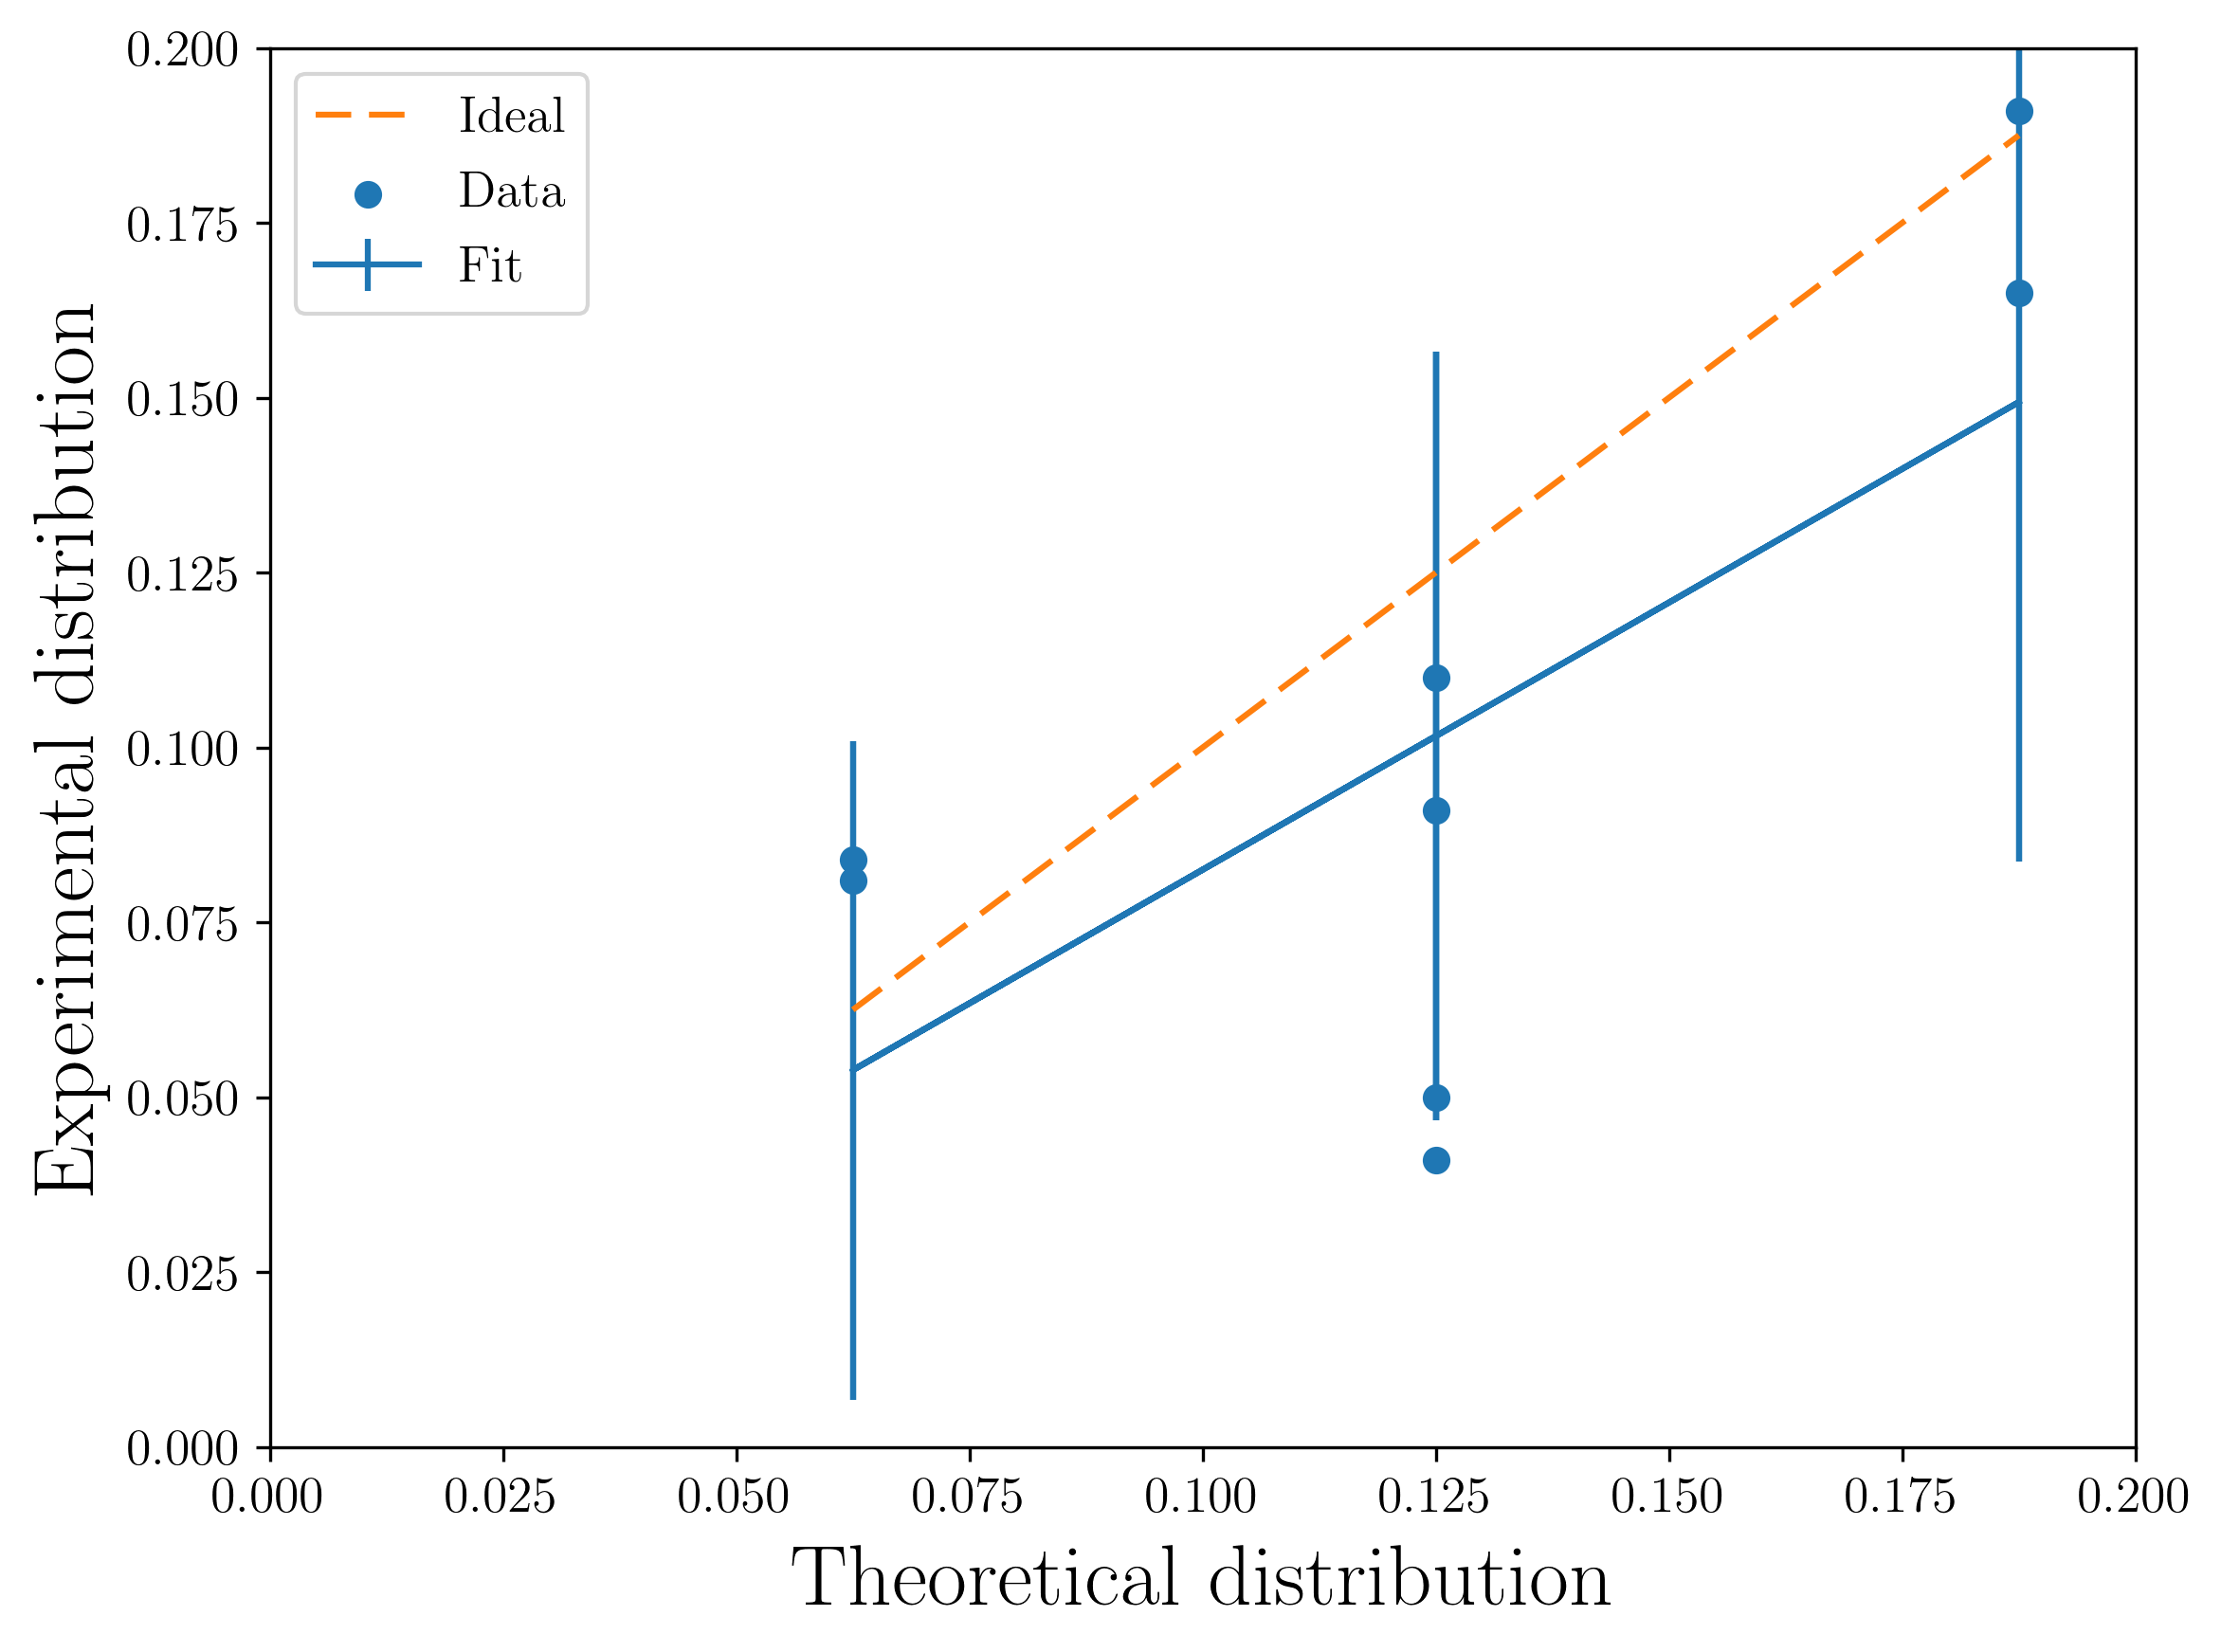

correlation coefficient:  0.68806829350248
error on correlation coeff 0.022969920722383224
p-value:  0.05923425754075006


In [11]:
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import pearsonr
import numpy as np

#changes plot parameters
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def pp_plot(exp, outcomes, filename):
    x_data = np.zeros(len(outcomes))
    y_data = np.zeros(len(exp))

    #find cdf
    x_data = (outcomes)
    y_data = (exp)

    x = np.linspace(min(x_data),max(x_data),len(x_data))

    y_fit_err = np.zeros(len(exp))


    # define fit function
    def test_func(x, a, b):
        return a * x + b

    # find parameters of fit function which fit data starting with guess parameters p0
    # params[0] = a, params[1] = b
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data, p0=[1,0])

    # find error on parameterds of the fit
    # params_err[0] = a_err, params_err[1] = b_err
    params_err = np.sqrt(np.diag(params_covariance))
    y_fit_err = np.sqrt( (test_func(x_data, params[0], params[1])*params_err[0])**2 + params_err[1]**2 )


#     print('fit parameters[angular coeff, offset]: ',params)
#     print('parameter errors',params_err)

    # plot data and fit
    plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.scatter(x_data, y_data, label='Data')
    plt.errorbar(x_data, test_func(x_data, params[0], params[1]), yerr =y_fit_err,  label='Fit')
    plt.plot(x,x,dashes=[6, 3], label='Ideal')
    plt.legend(loc='best')
    plt.xlabel("Theoretical distribution", fontsize=22)
    plt.ylabel("Experimental distribution", fontsize=22)
    plt.ylim((0,0.2))
    plt.xlim((0,0.2))
    
#     plt.title("a = 4, N=35")
    plt.savefig('%s.eps'%filename, dpi = 300)
    plt.show()
    
    
#     plt.figure(figsize=(6, 4))
#     plt.scatter(x_data, y_data, label='Data')
#     plt.errorbar(x_data, test_func(x_data, params[0], params[1]), yerr =y_fit_err,  label='Fitted distribution')
#     plt.plot(x,x, label='Ideal distribution')
#     plt.legend(loc='best')
#     plt.xlabel("Theoretical probability distribution")
#     plt.ylabel("Experimental probability distribution")
#     plt.show()
    
    print('correlation coefficient: ',pearsonr(outcomes,  exp)[0])
    print('error on correlation coeff',np.sqrt((1-(pearsonr(outcomes,  exp)[0])**2)/(1000-2)))
    print('p-value: ',pearsonr(outcomes,  exp)[1])


SHOTS = 1000

#load counts
a2 = np.load("a2_counts.npy")

print(a2)

def normalize(a):
    #normalizes vector
    for i in range(len(a)):
        a[i] = a[i]/1000
    return a

def sso(exp,th):
    sqrt_sso = 0
    
#     exp_norm = normalize(exp)
    for i in range(len(exp)):
        sqrt_sso += np.sqrt(exp[i])*np.sqrt(th[i])
    
    return sqrt_sso**2

def sso_error(exp,th):
    counts_err = np.zeros(len(exp)) #array with errors on counts
    for i in range(len(exp)):
        counts_err[i] = np.sqrt(exp[i]) # counting error 
        
    sso_err = 0 #error on the SSO
    
    #calculates error on SSO from errors on counts using Gaussian propagation of error
    
    for i in range(len(exp)):
        sso_err += (th[i]*counts_err[i])**2
    
    sso_err = np.sqrt(sso_err)
        
    return sso_err


# theoretical distribution of the period for a = 2
outcomes_r6 = np.zeros(8)
outcomes_r6[0] = 3/16
outcomes_r6[1] = 1/8
outcomes_r6[2] = 1/16
outcomes_r6[3] = 1/8
outcomes_r6[4] = 3/16
outcomes_r6[5] = 1/8
outcomes_r6[6] = 1/16
outcomes_r6[7] = 1/8

# theoretical distribution of the period for a = 4
outcomes_r3 = np.zeros(8)
outcomes_r3[0] = 33/96
outcomes_r3[1] = (4-2*np.sqrt(2))/32
outcomes_r3[2] = 1/16
outcomes_r3[3] = (4+2*np.sqrt(2))/32
outcomes_r3[4] = 3/96
outcomes_r3[5] = (4+2*np.sqrt(2))/32
outcomes_r3[6] = 1/16
outcomes_r3[7] = (4-2*np.sqrt(2))/32

# theoretical distribution of the period for a = 13
outcomes_r2 = np.zeros(8)
outcomes_r2[0] = 1/4
outcomes_r2[1] = 0
outcomes_r2[2] = 1/4
outcomes_r2[3] = 0
outcomes_r2[4] = 1/4
outcomes_r2[5] = 0
outcomes_r2[6] = 1/4
outcomes_r2[7] = 0

# theoretical distribution of the period for a = NA, r = 4
outcomes_r4 = np.zeros(8)
outcomes_r4[0] = 1/2
outcomes_r4[1] = 0
outcomes_r4[2] = 0
outcomes_r4[3] = 0
outcomes_r4[4] = 1/2
outcomes_r4[5] = 0
outcomes_r4[6] = 0
outcomes_r4[7] = 0

# theoretical distribution of the period for a = NA, r=5
outcomes_r5 = np.zeros(8)
outcomes_r5[0] = 7/32
outcomes_r5[1] = (8-3*np.sqrt(2))/64
outcomes_r5[2] = 1/8
outcomes_r5[3] = (8+3*np.sqrt(2))/64
outcomes_r5[4] = 1/32
outcomes_r5[5] = (8+3*np.sqrt(2))/64
outcomes_r5[6] = 1/8
outcomes_r5[7] = (8-3*np.sqrt(2))/64

# theoretical distribution of the period for a = NA, r=7
outcomes_r7 = np.zeros(8)
outcomes_r7[0] = 5/32
outcomes_r7[1] = (8+np.sqrt(2))/64
outcomes_r7[2] = 1/8
outcomes_r7[3] = (8-np.sqrt(2))/64
outcomes_r7[4] = 3/32
outcomes_r7[5] = (8-np.sqrt(2))/64
outcomes_r7[6] = 1/8
outcomes_r7[7] = (8+np.sqrt(2))/64



## SSO 
print('sso between experiment and theory for an input state (a=2) with period r=6', sso(a2,outcomes_r6*SHOTS)/(SHOTS**2), "with error: ", sso_error(a2,outcomes_r6*SHOTS)/(SHOTS**2))

pp_plot(a2/SHOTS, outcomes_r6, 'a2_21_pp')



/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


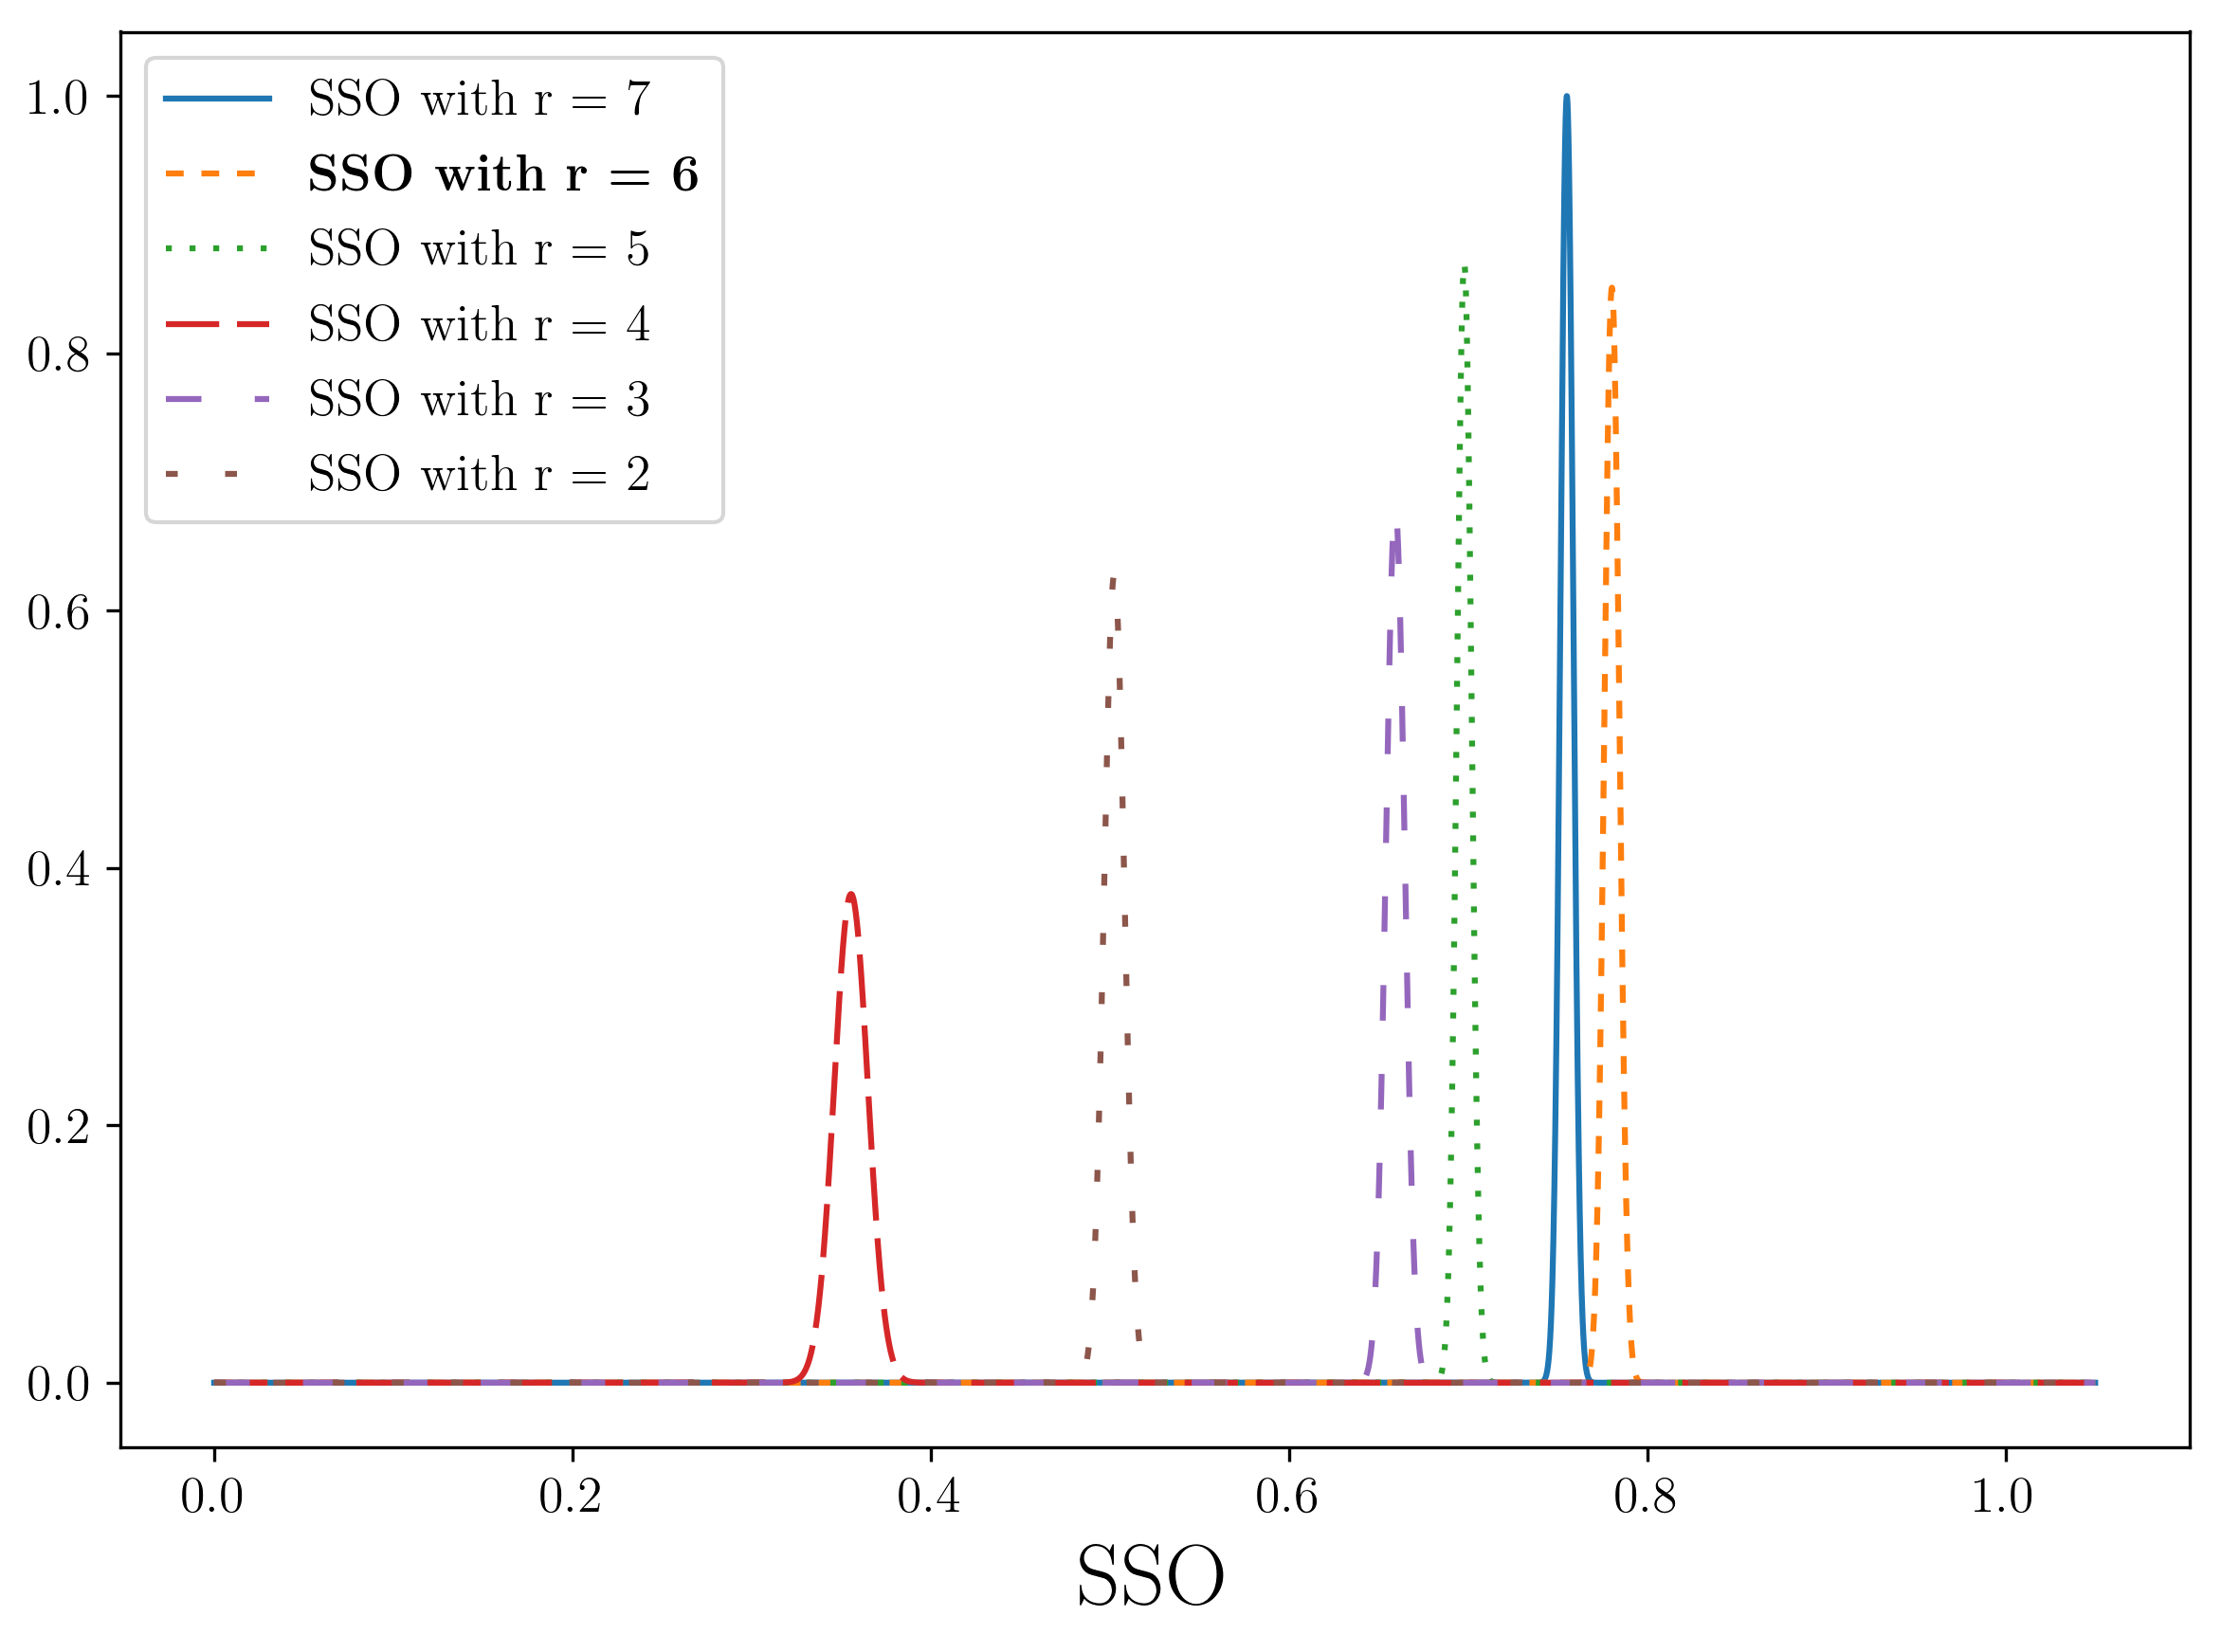

28.717457565457522


In [7]:
import pylab
import numpy as np
from scipy.stats import norm

#changes plot parameters
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


## Relative SSO

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')

x = np.linspace(0,1.05,10000)

y_6 = norm.pdf(x, loc=sso(a2,outcomes_r7*SHOTS)/(SHOTS**2), scale=sso_error(a2,outcomes_r7*SHOTS)/(SHOTS**2))    # loc = mean, scale = standard deviation
norm_fac = max(y_6) # find normalization factor
pylab.plot(x,y_6/norm_fac, label = 'SSO with r = 7')

y_1 = norm.pdf(x, loc=sso(a2,outcomes_r6*SHOTS)/(SHOTS**2), scale=sso_error(a2,outcomes_r6*SHOTS)/(SHOTS**2))    # loc = mean, scale = standard deviation
pylab.plot(x,y_1/norm_fac, dashes=[3, 3], label = r'\textbf{SSO with r = 6}')

y_5 = norm.pdf(x, loc=sso(a2,outcomes_r5*SHOTS)/(SHOTS**2), scale=sso_error(a2,outcomes_r5*SHOTS)/(SHOTS**2))    # loc = mean, scale = standard deviation
pylab.plot(x,y_5/norm_fac,dashes=[1, 3], label = 'SSO with r = 5')

y_4 = norm.pdf(x, loc=sso(a2,outcomes_r4*SHOTS)/(SHOTS**2), scale=sso_error(a2,outcomes_r4*SHOTS)/(SHOTS**2))    # loc = mean, scale = standard deviation
pylab.plot(x,y_4/norm_fac,dashes=[9, 3], label = 'SSO with r = 4')

y_2 = norm.pdf(x, loc=sso(a2,outcomes_r3*SHOTS)/(SHOTS**2), scale=sso_error(a2,outcomes_r3*SHOTS)/(SHOTS**2))    # loc = mean, scale = standard deviation
pylab.plot(x,y_2/norm_fac,dashes=[6, 9], label = 'SSO with r = 3')

y_3 = norm.pdf(x, loc=sso(a2,outcomes_r2*SHOTS)/(SHOTS**2), scale=sso_error(a2,outcomes_r2*SHOTS)/(SHOTS**2))    # loc = mean, scale = standard deviation
pylab.plot(x,y_3/norm_fac,dashes=[2, 8], label = 'SSO with r = 2')


# plt.title("a = 2, N=21, r=6")
plt.legend(loc='best')
plt.xlabel("SSO", fontsize=22)

plt.savefig('a2_21_sso.eps', dpi = 300)
pylab.show()


print(np.abs(sso(a2,outcomes_r6*SHOTS)/(SHOTS**2) - sso(a2,outcomes_r3*SHOTS)/(SHOTS**2))/(sso_error(a2,outcomes_r6*SHOTS)/(SHOTS**2)))